In [3]:
import os
import glob
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.interpolate import griddata
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

In [4]:
# To use PLUMBER2_GPP_common_utils, change directory to where it exists
os.chdir('/g/data/w97/mm3972/scripts/Land_Drought_Rainfall')
from common_utils import *

In [10]:
file_spinup   = '/g/data/w97/mm3972/model/cable/runs/Land_drought_rainfall_runs/spinup_run_1970_1999/outputs/cable_out_1970.nc'
file_gridinfo = '/g/data/w97/mm3972/scripts/Land_Drought_Rainfall/process_for_CABLE/nc_files/SG_smooth_anomaly/gridinfo_AWAP_OpenLandMap_ELEV_DLCM_fix_MODIS_LAI_albedo_lc_clim_common.nc'
f_sp          = Dataset(file_spinup, mode='r')
f_gridinfo    = Dataset(file_gridinfo, mode='r')

lat           = f_sp.variables['latitude'][:]
lon           = f_sp.variables['longitude'][:]
SM_sp         = f_sp.variables['SoilMoist'][0,:,:,:]
GW_SM_sp      = f_sp.variables['GWMoist'][0,:,:]
SM_gridinfo   = f_gridinfo.variables['ssat_vec'][:]*0.5

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


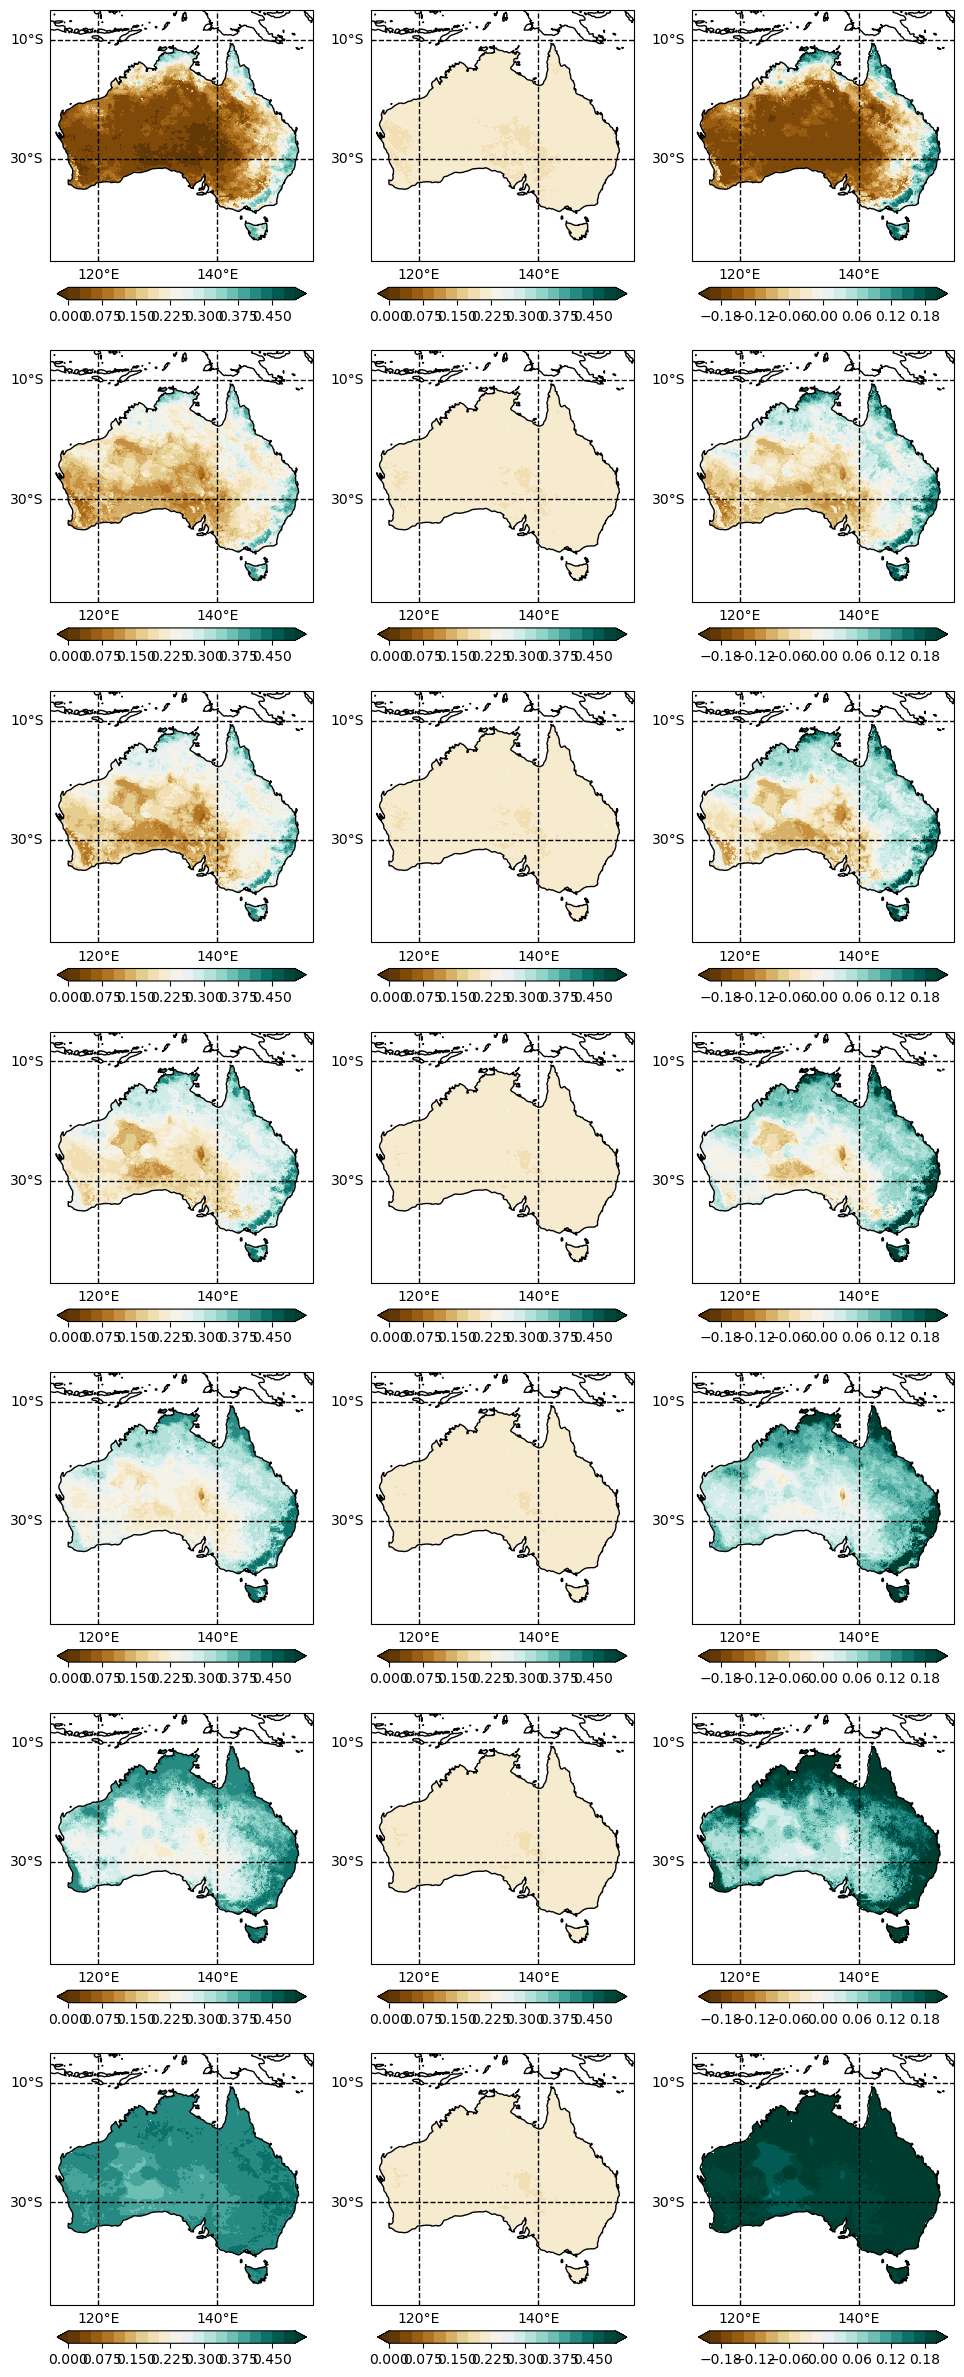

In [20]:
# Create a figure with 3 subplots in 1 row
fig, axs      = plt.subplots(nrows=7, ncols=3, figsize=(10, 24), 
                             subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.01)
loc_lat = None

# Flatten axs for consistent iteration
axs_flat = axs.flatten()

# Loop through each axis
for ax in axs_flat:

    # Set extent based on loc_lat and loc_lon
    if loc_lat is None:
        ax.set_extent([112, 156, -45, -5])  # Example extent, adjust as needed
    else:
        ax.set_extent([loc_lon[0], loc_lon[1], loc_lat[0], loc_lat[1]])

    ax.coastlines(resolution="50m", linewidth=1)

    # Add gridlines
    gl               = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', linestyle='--')
    gl.xlabels_top   = False
    gl.ylabels_right = False
    gl.xlines        = True

    if loc_lat is None:
        gl.xlocator = mticker.FixedLocator([120, 140])
        gl.ylocator = mticker.FixedLocator([-10, -30])
    else:
        gl.xlocator = mticker.FixedLocator(loc_lon)
        gl.ylocator = mticker.FixedLocator(loc_lat)

    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

# Plot windspeed based on variable names
clevs      = np.linspace(0, 0.5, num=21)
clevs_diff = np.linspace(-0.2, 0.2, num=21)

for row in np.arange(7):
    if row < 6:
        plot1 = axs[row, 0].contourf(lon, lat, SM_sp[row,:,:], levels=clevs, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
        plot2 = axs[row, 1].contourf(lon, lat, SM_gridinfo[row,:,:], levels=clevs, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
        plot3 = axs[row, 2].contourf(lon, lat, SM_sp[row,:,:]-SM_gridinfo[row,:,:],  levels=clevs_diff, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
    else:
        plot1 = axs[row, 0].contourf(lon, lat, GW_SM_sp[:,:], levels=clevs, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
        plot2 = axs[row, 1].contourf(lon, lat, SM_gridinfo[5,:,:], levels=clevs, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
        plot3 = axs[row, 2].contourf(lon, lat, GW_SM_sp[:,:]-SM_gridinfo[5,:,:],  levels=clevs_diff, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)

    cb = plt.colorbar(plot1, ax=axs[row, 0], orientation="horizontal", pad=0.08, aspect=20, shrink=0.8)
    cb = plt.colorbar(plot2, ax=axs[row, 1], orientation="horizontal", pad=0.08, aspect=20, shrink=0.8)
    cb = plt.colorbar(plot3, ax=axs[row, 2], orientation="horizontal", pad=0.08, aspect=20, shrink=0.8)
    cb.ax.tick_params(labelsize=10)


fig.tight_layout()
plt.savefig('./plots/Compare_SM_spinup_vs_half_full.png',dpi=300)

### CABLE soil is too wet! That might be the reason why ET is too high relative to GLEAM